In [2]:
#Import all packages for the Yelp Project
#Create connection to connection to created database

import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
conn = sqlite3.connect('yelp.db')
#:memory:
cur = conn.cursor()

In [3]:
#Create two variables for the business and review databases from yelp

url = 'https://api.yelp.com/v3/businesses/search'
url2 = 'https://api.yelp.com/v3/businesses/{id}/reviews'

In [4]:
#Connection to the Yelp API with the keys created 
client_id = "WdeBQ0QfW7ctlNNGDyNEwA"
api_key = "qOP1w_dBiefuyHCkz5gzIlhtKzNxBNMi3uCVJib_Kzs_y0EKqn1pKpRlpGvAPmB2fZ_eVWv65j_o5rmiT9HNK10tH5rosM3GfauVdQU0TvfOtdqn4L3zzLC2g1P3X3Yx"

In [5]:
#Creates a header with the attached API key from the Yelp API
headers = {
        'Authorization': 'Bearer {}'.format(api_key),
    }

In [6]:
#Creates the conditiions for which we want to search for for a specific business
# Searched by Yoga business within Manahttan for a 10,000 meter radius or 6.4 miles
term = 'yoga'
location = 'Manhattan'
radius = 10000

In [7]:
#Inputs our condtions into the business earch API to give
#all business related to our condtions

url_params = {
                "term": term.replace(' ', '+'),
                "location": location.replace(' ', '+'),
                "radius" : radius,
                "limit": 50
            }

In [8]:
#Creates a yelp call function that takes into three different paramters:
#Takes in the business url, conditons we search for, then the key from teh API we need
#to access the data, then returns a data base based on these condtions of the give business

def yelp_call(url, url_params, api_key):
    # your code to make the yelp call
    response = requests.get(url, headers=headers, params=url_params)
    data = response.json()
    return data

In [9]:
NYCdata = yelp_call(url, url_params, api_key)

In [10]:
NYCdata

{'businesses': [{'id': 'kmj7FnZsKPPH3psbR9tX7Q',
   'alias': 'sonic-yoga-new-york',
   'name': 'Sonic Yoga',
   'image_url': 'https://s3-media2.fl.yelpcdn.com/bphoto/72XvEESqvzJCTA5E4o9XiA/o.jpg',
   'is_closed': False,
   'url': 'https://www.yelp.com/biz/sonic-yoga-new-york?adjust_creative=WdeBQ0QfW7ctlNNGDyNEwA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=WdeBQ0QfW7ctlNNGDyNEwA',
   'review_count': 146,
   'categories': [{'alias': 'yoga', 'title': 'Yoga'}],
   'rating': 4.5,
   'coordinates': {'latitude': 40.7657608, 'longitude': -73.9831765},
   'transactions': [],
   'location': {'address1': '944 8th Ave',
    'address2': 'Fl 2',
    'address3': '',
    'city': 'New York',
    'zip_code': '10019',
    'country': 'US',
    'state': 'NY',
    'display_address': ['944 8th Ave', 'Fl 2', 'New York, NY 10019']},
   'phone': '+12123976344',
   'display_phone': '(212) 397-6344',
   'distance': 731.7016468023255},
  {'id': 'GgvXfu8U80tcrxythjpB4w',
   'alias': 'atth

In [11]:
#Create a SQL datatable were we will insert the information from the businesses returned 
#from the API.


cur.execute("""CREATE TABLE businesses (
                                id INTEGER PRIMARY KEY, 
                                businessID TEXT,
                                rating INTEGER,
                                price TEXT,
                                name TEXT,
                                review_count TEXT,
                                city TEXT,
                                country TEXT,
                                zip_code TEXT
                                )          
            """)
conn.commit()

OperationalError: table businesses already exists

In [12]:
#Create a SQL datatable were we will insert the information from the businesses 
#for three reviews given to each business returned 
#from the API.

cur.execute("""CREATE TABLE reviews (
                                businessID TEXT,
                                text TEXT,
                                rating INTEGER,
                                time_created TEXT,
                                reviewID TEXT
                                )          
            """)
conn.commit()

OperationalError: table reviews already exists

In [13]:
# Creating a function that parses that data then returns the information as a tuple
def parse_results(results):
#empty list of all the information we want to pull for the yoga businesses 
    biz_list = []

    #Iterate through all the businesses keys to pull out the relvant information from each key
    for business in results['businesses']:
        for item in ['businessID', 'rating', 'price', 'name', 'review_count', 'city', 'country', 'zip_code']:
            #If the value is not found for a given key then replace it with a NAN value
            if item not in business:
                business[item] = np.nan
            else: 
                business[item]
        #Grabs each value and appends to a list
        biz_tuple = ( business['id'], 
                      business['rating'],
                      business['price'],
                      business['name'],
                      business['review_count'],
                      business['location']['city'],
                      business['location']['country'],
                      business['location']['zip_code']
                      )    
        biz_list.append(biz_tuple)
    return biz_list

In [14]:
#Takes the values from the parsed results and inputs them into the business table
def insert_values(conn, cur, parse_results):
        add_business = ("""
    INSERT INTO businesses (businessID, rating, price, name, review_count, city, country, zip_code)
    VALUES (?, ?, ?, ?, ?, ?, ?, ?) """)
        cur.executemany(add_business, parse_results)
        conn.commit()
        

In [15]:
# create a variable  to keep track of which result you are in. 
current_offset = 0
#set up a while loop to go through and grab the result 
while current_offset < 1000:
    #set the offset parameter to be where you currently are in the results 
    url_params['offset'] = current_offset
    #make your API call with the new offset number
    results = yelp_call(url, url_params, api_key)
    #after you get your results you can now use your function to parse those results
    parsed_results = parse_results(results)
    # use your function to insert your parsed results into the db
    insert_values(conn, cur, parsed_results)
    #increment the counter by 50 to move on to the next results
    current_offset += 50
    print(current_offset)

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000


In [16]:
# Our second coniditon is London as we are comparing and contrasting NYC to London to setup
# a yoga studio.
location = 'London'

In [54]:
# Takes in our new condtions, being a new location and outputs all the business that
# are yoga studios within London

url_params = {
                "term": term.replace(' ', '+'),
                "location": location.replace(' ', '+'),
                "radius" : radius,
                "limit": 50
            }

In [17]:
# create a variable  to keep track of which result you are in. 
current_offset = 0
#num = NYCdata['total']
#set up a while loop to go through and grab the result 
while current_offset < 1000:
    #set the offset parameter to be where you currently are in the results 
    url_params['offset'] = current_offset
    #make your API call with the new offset number
    results = yelp_call(url, url_params, api_key)
    
    #after you get your results you can now use your function to parse those results
    parsed_results = parse_results(results)
    
    # use your function to insert your parsed results into the db
    insert_values(conn, cur, parsed_results)
    #increment the counter by 50 businesses at a time to move on to the next results
    print(current_offset)
    current_offset += 50

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


In [18]:
#Grabs all the the businesses IDs from SQL and puts them into a list of tuples
biz_list = cur.execute("""
SELECT businessID
FROM businesses;
""").fetchall()

In [19]:
biz_list

[('kmj7FnZsKPPH3psbR9tX7Q',),
 ('GgvXfu8U80tcrxythjpB4w',),
 ('TlDcvf1cEK2im6e4AFYe3A',),
 ('npgq_up0_puDV5jieUza-A',),
 ('Oi85AYz9-Bx-9SBjNf__vg',),
 ('nuhFcWqgHBwmgwlbm4rI9w',),
 ('Chuu09nqfEQbREmaphoOuw',),
 ('FK_6tqTQuSkadiWQ1w8ttQ',),
 ('nkUwnPPYmCICZ8nYCu_twg',),
 ('XpY0Cxo_Iw2deqeY6zsNOA',),
 ('tGtrhu0YDGkM9ECrYVz6xg',),
 ('omwcHHgdgUJn-W1b3i78og',),
 ('Mc17IR6PG4iZLmZzciJEQQ',),
 ('oECxp7RoWT2QArWgqpwnMA',),
 ('x0bjd5AUu3ASzfjmht2IYA',),
 ('c_80f3N3NbWDX8RnvuM3Xg',),
 ('89VGtFw9HZASM0IdnSEeFA',),
 ('KjSI9xkCFTrRRbHOzCG7xg',),
 ('PZhmOvUx0HrdGvxVrxTJ5g',),
 ('b1ziC3xpS5Bb9PGsufBYAw',),
 ('NqL3lVZgh1pz0tVaZBxkRg',),
 ('vxNBDgBMP44E8DHuqj5z6A',),
 ('dzvqCMHOsvruyOZZ8wSnbA',),
 ('I3-EsRgXDcLx3OrlACCx3Q',),
 ('qFJcpI5TOBQkX6BukZqUVw',),
 ('6-fZD_ZzKJo29zapElbOZg',),
 ('HcsOCtxnSpAmUU0EC_AGMQ',),
 ('JvwVi-ZOfGKQEiezZTCgEA',),
 ('PISWOLCiOj47QbZKm-F3tg',),
 ('cwADiq0xORmv4QA2jhu-Pw',),
 ('fiLGdKwhkvK6pZ3E_GjHmQ',),
 ('qhjcMZivcYfr7CaTHkiXXg',),
 ('P5OZCF6xChJtWNrjNFBBRA',),
 ('gbRr9zR

In [20]:
#Makes a new list of all the ID's of busineess that takes them out of the tuple
biz_ID_list = []
for biz in biz_list:
    biz_ID = biz[0]
    biz_ID_list.append(biz_ID)
biz_ID_list

['kmj7FnZsKPPH3psbR9tX7Q',
 'GgvXfu8U80tcrxythjpB4w',
 'TlDcvf1cEK2im6e4AFYe3A',
 'npgq_up0_puDV5jieUza-A',
 'Oi85AYz9-Bx-9SBjNf__vg',
 'nuhFcWqgHBwmgwlbm4rI9w',
 'Chuu09nqfEQbREmaphoOuw',
 'FK_6tqTQuSkadiWQ1w8ttQ',
 'nkUwnPPYmCICZ8nYCu_twg',
 'XpY0Cxo_Iw2deqeY6zsNOA',
 'tGtrhu0YDGkM9ECrYVz6xg',
 'omwcHHgdgUJn-W1b3i78og',
 'Mc17IR6PG4iZLmZzciJEQQ',
 'oECxp7RoWT2QArWgqpwnMA',
 'x0bjd5AUu3ASzfjmht2IYA',
 'c_80f3N3NbWDX8RnvuM3Xg',
 '89VGtFw9HZASM0IdnSEeFA',
 'KjSI9xkCFTrRRbHOzCG7xg',
 'PZhmOvUx0HrdGvxVrxTJ5g',
 'b1ziC3xpS5Bb9PGsufBYAw',
 'NqL3lVZgh1pz0tVaZBxkRg',
 'vxNBDgBMP44E8DHuqj5z6A',
 'dzvqCMHOsvruyOZZ8wSnbA',
 'I3-EsRgXDcLx3OrlACCx3Q',
 'qFJcpI5TOBQkX6BukZqUVw',
 '6-fZD_ZzKJo29zapElbOZg',
 'HcsOCtxnSpAmUU0EC_AGMQ',
 'JvwVi-ZOfGKQEiezZTCgEA',
 'PISWOLCiOj47QbZKm-F3tg',
 'cwADiq0xORmv4QA2jhu-Pw',
 'fiLGdKwhkvK6pZ3E_GjHmQ',
 'qhjcMZivcYfr7CaTHkiXXg',
 'P5OZCF6xChJtWNrjNFBBRA',
 'gbRr9zRxpBtBLum9kMlxZw',
 'hW_eQNgyPkfwAH4Gq6I6LQ',
 'Vi_qAjnkRk4kCaMpx_-Gkg',
 'Vwy58_3fyh1LwcMCFGb5vQ',
 

In [21]:
#Grabs all three reviews for each business when we input the ID from the business list 
#Created above and then outputs a dataframe 

def yelp_call_reviews(ID):
        url = 'https://api.yelp.com/v3/businesses/{}/reviews'.format(ID)
    # your code to make the yelp call
        response = requests.get(url, headers=headers)
        data = response.json()
        return data

In [22]:
#We need to know parse the inforamtion given from the reviews table 
def parse_reviews(businessID, review_results):
    #Creates a tuple list of all the information extract from the Yelp reveiws for each 
    #business 
    tuple_lists = []
    
    #Checks if there is a missing reveiw and returns None if there is a missing review
    if 'error' in review_results:
        if review_results['error']['code'] == 'BUSINESS_UNAVAILABLE':
            return None
     #else check for missing values for the within the keys and returns none       
    else:
        for review in review_results['reviews']:
            for item in ['text', 'rating', 'time_created']:
                if item not in review:
                    review[item] = np.nan
                #Populates the a tuple list if the value is present
                review_tuple =( businessID, 
                                review['text'],
                                review['rating'],
                                review['time_created'],
                                review['id']
                              )
                tuple_lists.append(review_tuple)
    
    return tuple_lists

In [23]:
#Insert the values from the parsed data into our reviews table 

def insert_reviews(conn, cur, parse_reviews):
        add_reviews = ("""
        INSERT INTO reviews (businessID, text, rating, time_created, reviewID)
        VALUES (?, ?, ?, ?, ?) """)
        cur.executemany(add_reviews, parse_reviews)
        conn.commit()

In [24]:

#Goes into each business ID and puts into the yelp_call to grab reviews assocated with one 
#specific business
for biz in biz_ID_list:
    review_results = yelp_call_reviews(biz)
    #If we get a Nan or None value we then move onto the next one 
    if review_results == None:
        pass
    #Takes all the results we got from reviews and then parses them into the tuple
    parsed_reviews = parse_reviews(biz, review_results)
    #takes the tuple and inserts the information into the table called reviews 
    insert_reviews(conn, cur, parsed_reviews)

In [24]:
#Checking that we have a SQL database for all the businesses in NYC and London
cur.execute("""
SELECT * FROM businesses
""")
df = pd.DataFrame(cur.fetchall())
df.columns = [x[0] for x in cur.description]
df

,id,businessID,rating,price,name,review_count,city,country,zip_code
0,1,kmj7FnZsKPPH3psbR9tX7Q,4.5,None,Sonic Yoga,146,New York,US,10019
1,2,GgvXfu8U80tcrxythjpB4w,5.0,None,AtthenaYoga,42,New York,US,10036
2,3,TlDcvf1cEK2im6e4AFYe3A,4.5,None,Humming Puppy,90,New York,US,10011
3,4,npgq_up0_puDV5jieUza-A,4.5,None,Yo Yoga!,55,New York,US,10022
4,5,Oi85AYz9-Bx-9SBjNf__vg,4.5,None,Yoga Spa Lounge 1881,92,New York,US,10022
...,...,...,...,...,...,...,...,...,...
2174,2175,uis6vcPyUFHb0FTGy1zfRQ,5.0,None,Earth's Healings,2,River Edge,US,07661
2175,2176,P296OXS_TPa_c_pP2GsSdg,4.0,None,Brooklyn Zoo NY,45,Brooklyn,US,11206
2176,2177,GLzJ-DWZQ6tn1gjtI_IhzQ,5.0,None,Awaken Integrative Movement,4,Brooklyn,US,11238
2177,2178,kW8wW3yJBUFn8RVK9dQFqg,2.5,None,New York Sports Clubs,119,New York,US,10014


In [25]:
#Checks to see if all the values where populated into the reviews database
cur.execute("""
SELECT * FROM reviews
""")
df = pd.DataFrame(cur.fetchall())
df.columns = [x[0] for x in cur.description]
df

,businessID,text,rating,time_created,reviewID
0,kmj7FnZsKPPH3psbR9tX7Q,"Beginner Flow with Taquice, Sunday afternoon -...",5,2019-12-29 14:26:23,QJS08cT1I7c0Ev9u6femLw
1,kmj7FnZsKPPH3psbR9tX7Q,"Beginner Flow with Taquice, Sunday afternoon -...",5,2019-12-29 14:26:23,QJS08cT1I7c0Ev9u6femLw
2,kmj7FnZsKPPH3psbR9tX7Q,"Beginner Flow with Taquice, Sunday afternoon -...",5,2019-12-29 14:26:23,QJS08cT1I7c0Ev9u6femLw
3,kmj7FnZsKPPH3psbR9tX7Q,I came across Sonic Yoga on ClassPass. I have...,4,2020-02-28 06:21:41,1lBvdI7kfUrWN59njKQsZw
4,kmj7FnZsKPPH3psbR9tX7Q,I came across Sonic Yoga on ClassPass. I have...,4,2020-02-28 06:21:41,1lBvdI7kfUrWN59njKQsZw
...,...,...,...,...,...
9322,s0W-AbYi0mGw6egZ2rk_Ow,This location puts San Francisco Equinox Sport...,4,2016-08-01 12:34:31,1s1M_DJNdqHvEg2xLHChYQ
9323,s0W-AbYi0mGw6egZ2rk_Ow,This location puts San Francisco Equinox Sport...,4,2016-08-01 12:34:31,1s1M_DJNdqHvEg2xLHChYQ
9324,s0W-AbYi0mGw6egZ2rk_Ow,My father's old business partner's daughter in...,3,2018-08-08 08:30:27,sJdmd9ZYZf-BJ4SNKI-iVw
9325,s0W-AbYi0mGw6egZ2rk_Ow,My father's old business partner's daughter in...,3,2018-08-08 08:30:27,sJdmd9ZYZf-BJ4SNKI-iVw


In [26]:
#SQL queries 
# Which are the 5 most reviewed businesses?
cur.execute("""
SELECT name 
FROM businesses
ORDER By review_count DESC
LIMIT 5
""").fetchall()

[('Vanderbilt Branch YMCA',),
 ('Vanderbilt Branch YMCA',),
 ('Work it Out',),
 ('Foxy Fitness & Pole Training Studios',),
 ('Church Street Boxing Gym',)]

In [27]:
#What is the highest rating recieved in your data set and how many businesses have that rating?
cur.execute("""
SELECT rating, COUNT(rating)
FROM businesses
WHERE rating = (SELECT MAX(rating) FROM businesses)
""").fetchall()

[(5, 1008)]

In [28]:
# What percentage of businesses have a rating greater than or 4.5?
cur.execute("""
SELECT
COUNT(*)*100/ (SELECT COUNT(*) FROM businesses)
FROM businesses 
WHERE rating < 4.5
""").fetchall()

[(30,)]

In [29]:
# What percentage of businesses have a rating less than 3?
cur.execute("""
SELECT
COUNT(*)*100/ (SELECT COUNT(*) FROM businesses)
FROM businesses 
WHERE rating < 3
""").fetchall()

[(3,)]

In [30]:
# What is the average rating of businesses that have a price label of one dollar sign? 
# Two dollar signs? Three dollar signs?
cur.execute("""
SELECT AVG(rating) AS AvgRating, price
FROM businesses
GROUP BY price
HAVING price = '$' OR price = '$$' OR price = '$$$'
""").fetchall()

[(4.25, '$'), (4.1923076923076925, '$$'), (3.4516129032258065, '$$$')]

In [31]:
#Return the text of the reviews for the most reviewed business.
cur.execute("""
SELECT text
FROM reviews
WHERE businessID in (SELECT businessID
                     FROM businesses
                     ORDER BY review_count
                     LIMIT 1
                     );
""").fetchall()

[('I came away very impressed after some session stress management and yoga sessions with Eiji. His calm demeanor and clear instructions made it a very easy to...',),
 ('I came away very impressed after some session stress management and yoga sessions with Eiji. His calm demeanor and clear instructions made it a very easy to...',),
 ('I came away very impressed after some session stress management and yoga sessions with Eiji. His calm demeanor and clear instructions made it a very easy to...',)]

In [32]:
# Return the name of the business with the most recent review.
cur.execute("""
SELECT name
FROM businesses
WHERE businessID in (SELECT businessID
                     FROM reviews
                     ORDER BY time_created DESC
                     LIMIT 1);

""").fetchall()

[('Five Pillars Yoga',), ('Five Pillars Yoga',)]

In [33]:
# Find the highest rated business and return text of the most recent review. 
# If multiple business have the same rating, select the business with the most reviews.
cur.execute("""
SELECT text
FROM reviews AS r
JOIN businesses AS b
ON r.businessID = b.businessID
ORDER BY review_count DESC, b.rating DESC
LIMIT 1
""").fetchall()

[('I was member here for 15+ years. The karate program was pretty good, most of the staff is great (with the exception to a few people), the gym is nice and...',)]

In [34]:
# Find the lowest rated business and return text of the most recent review. 
# If multiple business have the same rating, select the business with the least reviews.
cur.execute("""
SELECT text
FROM reviews AS r
JOIN businesses AS b
ON r.businessID = b.businessID
ORDER BY  b.rating ASC, review_count ASC
LIMIT 1
""").fetchall()

[('Participated in a photo shoot for this studio way back in 2018, and was promised TFP not long after. 2 years and multiple failed contact attempts later,...',)]

In [55]:
#Creating a datframe based on the businesses where we get the rating and city where we 
#group by the country

Avg_Country = cur.execute("""
SELECT rating, city
FROM businesses
GROUP BY country 
""").fetchall()

In [56]:
#Creates dataframe for the country and the average rating by country
Avg_Country = df.groupby('country')['rating'].mean()

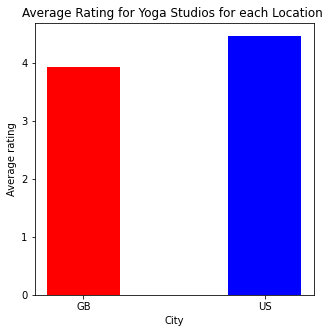

In [57]:
#Creates a visualization based on the average rating for eacb location 

fig, ax = plt.subplots(figsize=(5, 5))

ax.bar(Avg_Country.index, Avg_Country.values, color = ('Red', 'blue'), width = 0.4)

ax.set_xlabel("City")
ax.set_ylabel("Average rating")
ax.set_title("Average Rating for Yoga Studios for each Location ")
plt.show()

In [81]:
#SQL query grabbing the rating and review_count for each city 
cur.execute("""
SELECT city, rating, review_count
FROM businesses
GROUP BY country
""")
avgR = pd.DataFrame(cur.fetchall())
avgR.columns = [x[0] for x in cur.description]
avgR


,city,rating,review_count
0,London,5.0,1
1,New York,4.5,146


In [83]:
avgR['review_count'] = avgR['review_count'].map(lambda x : int(x))
avgR['review_count']

0      1
1    146
Name: review_count, dtype: int64

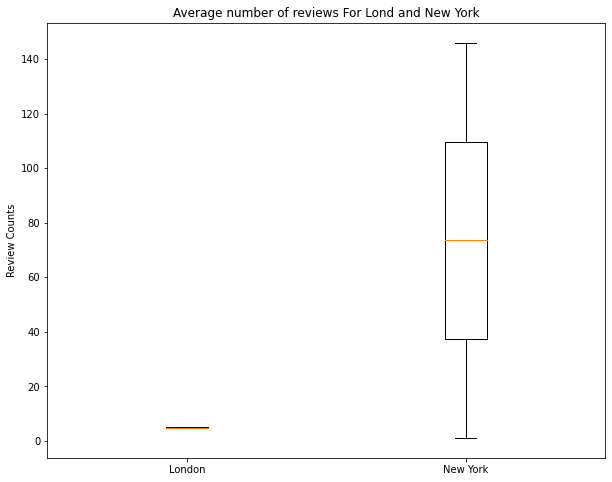

In [84]:
#Box plot showing the mean review counts by the number of ratings for each area 
fig, ax = plt.subplots(figsize = (10,8))

# Add data: "raitng", "review count" from the dataframe
ax.boxplot([avgR['rating'], avgR['review_count']])


# Set the x-axis label to "London and New York"
ax.set_xticklabels(['London', "New York"])

# Set the y-axis label to "Review Counts"
ax.set_ylabel("Review Counts")

#set the title for the boxplot
ax.set_title('Average number of reviews For Lond and New York')


plt.show()

In [85]:
#Creates a query the prices for each areas in NYC

cur.execute("""
SELECT price, city, review_count
FROM businesses 
WHERE price = '$$$$' OR price = '$$$' OR price = '$$' OR price = '$'
""")
priceNYCdb = pd.DataFrame(cur.fetchall())
priceNYCdb.columns = [x[0] for x in cur.description]
priceNYCdb

,price,city,review_count
0,$$,New York,10
1,$$,New York,1
2,$$,Jersey City,40
3,$$$,New York,269
4,$$$,Guttenberg,38
...,...,...,...
93,$$,Jersey City,14
94,$$$,New York,148
95,$$$,New York,105
96,$$$,New York,76


In [47]:
# Replaces all the $ with 1 through 4 value for leas tto most epxensive 
newcolumn = []

for x in priceNYCdb['price']:
    if x == '$':
        newcolumn.append(int(x.replace('$', str(1))))
    if x == '$$':
        newcolumn.append(int(x.replace('$$', str(2))))
    if x == '$$$':
        newcolumn.append(int(x.replace('$$$', str(3))))
    if x == '$$$$':
        newcolumn.append(int(x.replace('$$$$', str(4))))

In [48]:
#Adds the new column for the conversion of the symbol to the numeric value 
priceNYCdb['newPrice'] = newcolumn

In [49]:
#Creates a query the prices for each areas in Lodnon
cur.execute("""
SELECT price, city, review_count
FROM businesses 
WHERE price = '££££' OR price = '£££' OR price = '££' OR price = '£'

""")
priceUKdb = pd.DataFrame(cur.fetchall())
priceUKdb.columns = [x[0] for x in cur.description]
priceUKdb

,price,city,review_count
0,££,London,8
1,£££,London,7
2,£££,Soho,15
3,££,London,5
4,£££,London,2
5,££,London,6
6,££££,London,7
7,£££,London,4
8,££,London,2
9,££££,London,2


In [50]:
# Replaces all the £ with 1 through 4 value for leas tto most epxensive 


newcolumnUK = []

for x in priceUKdb['price']:
    if x == '£':
        newcolumnUK.append(int(x.replace('£', str(1))))
    if x == '££':
        newcolumnUK.append(int(x.replace('££', str(2))))
    if x == '£££':
        newcolumnUK.append(int(x.replace('£££', str(3))))
    if x == '££££':
        newcolumnUK.append(int(x.replace('££££', str(4))))

In [77]:
#Adds the new column to the london database
priceUKdb['newPrice'] = newcolumnUK 

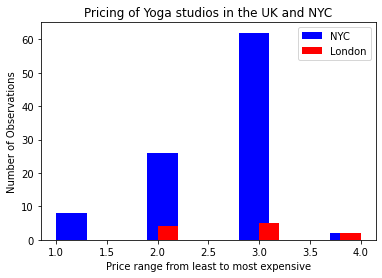

In [52]:
#Hsitogram of the fo

fig, ax = plt.subplots()
# Plot a histogram of "Price" for each NYC 
ax.hist(priceNYCdb['newPrice'], label = 'NYC',  color = 'blue')

# Compare to histogram of "Price" for London
ax.hist(priceUKdb['newPrice'], label= 'London', color = 'red')

# Set the x-axis label to "Price Range for Yoga studios"
ax.set_xlabel('Price range from least to most expensive')

# Set the y-axis label to "# of observations"
ax.set_ylabel('Number of Observations')
#Title for the our histogram 
ax.set_title('Pricing of Yoga studios in the UK and NYC')

#Creates the legend to identify what color is for what location 
ax.legend()
plt.show()

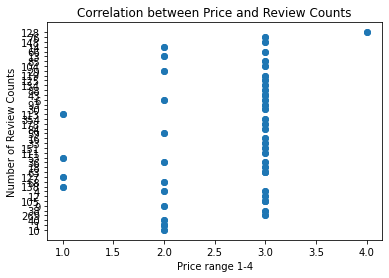

In [53]:
fig, ax = plt.subplots()

# Add data: "height", "weight" as x-y, index as color
ax.scatter(priceNYCdb["newPrice"], priceNYCdb["review_count"])

# Set the x-axis label to "CO2 (ppm)"
ax.set_xlabel("Price range 1-4")

# Set the y-axis label to "Relative temperature (C)"
ax.set_ylabel("Number of Review Counts")

ax.set_title('Correlation between Price and Review Counts')


plt.show()